# Data Wrangling And Engineering

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

## Reading And Renaming Columns

In [ ]:
dfy = pd.read_csv('data.csv', encoding='utf-8')
dfy.drop(columns=['fingerprint','user_id','search'],inplace=True) 

In [ ]:
dfy.columns = ['id_x',
 'refererPage',
 'sec',
 'pathname',
 'state_id',
 'state',
 'city_id',
 'city',
 'has_houses',
 'type_children',
 'land_use',
 'when_to_buy',
 'born',
 'age',
 'status',
 'childrens',
 'credit_type',
 'income',
 'time_worked',
 'credit',
 'points',
 'payment_method',
 'has_credit',
 'eventName',
 'help',
 'advance_payment',
 'bureau_credit'] #Renaming columns

## Feature Engineering

In [ ]:
dfy['id_x'].astype(str)
dfy['id_x'] = dfy['id_x'].apply(lambda x: re.sub('@?[a-zA-z]*','', x))
dfy['id_x'] = dfy['id_x'].apply(lambda x: re.sub('[].-]*','', x))

In [ ]:
dfy['id_x'] = dfy['id_x'].astype(int)
dfy = dfy.set_index(['id_x', 'refererPage'])
dfy = dfy.sort_index(ascending=True)
dfy_un = pd.DataFrame(dfy.reset_index())

## Coding The Funnel

In [ ]:
a = list(dfy_un['id_x'].unique())
diccionario = {}
for index in a:
    lista = []

    temp = dfy_un.query('id_x == {}'.format(index))
    referers = list(temp['refererPage'])

    funnel_base= ['precalificate','tipocredito', 'ingresoMensual', 'tiempoLaborando']
    funnel_1 = 'sinPuntos'
    funnel_2 = ['creditoCTA','thankYou']
    funnel_3 = ['ingresoExtra','registerCta','cta','thankYou']
    funnel_3_1 = 'noPerfila'
    funnel_4 = ['buro','registerCreditoCta','creditoCTA','thankYou' ]
    #funnel_4_1 = 'creditoInsuficiente'
    funnel_5 = 'noAplica'

    for x in funnel_base:
        check = x in referers
        lista.append(check)
        
    if all(lista):
        if funnel_1 in referers:
            diccionario[str(index)]='SinPuntos'
        elif funnel_5 in referers:
            diccionario[str(index)]='NoAplico'

        elif 'registerCreditoCta' in referers and 'enganche' not in referers:
            new_list = []
            for x in funnel_2:
                check = x in referers
                new_list.append(check)
            if all(new_list):
                diccionario[str(index)]='Funnel_2_completo'

        elif 'creditoInsuficiente' in referers and 'enganche' not in referers:
            if 'noPerfila' in referers:
                diccionario[str(index)]='NoPerfila'
            else:
                new_list = []
                for x in funnel_3:
                    check = x in referers
                    new_list.append(check)
                if all(new_list):
                    diccionario[str(index)]='Funnel_3_completo'

        elif 'enganche' in referers:
            if 'buro' in referers:
                if 'noPerfila' in referers:
                    diccionario[str(index)]='NoPerfila_enganche'
                elif 'buro' in referers and 'creditoInsuficiente' in referers:
                    new_list = []
                    for x in funnel_3:
                        check = x in referers
                        new_list.append(check)
                    if all(new_list):
                        diccionario[str(index)]='Funnel_4_completo_insuficiente'

                elif 'buro' in referers and 'registerCreditoCta' in referers:
                    new_list = []
                    for x in funnel_2:
                        check = x in referers
                        new_list.append(check)
                    if all(new_list):
                        diccionario[str(index)]='Funnel_4_completo_register'
    else:
        diccionario[str(index)]='Fracaso'

## Merging Funnel With The DataFrame And Saving It

In [ ]:
dfy_un_experimental = dfy_un.copy()

indices = list(diccionario.keys())
resultados = list(diccionario.values())
lista_de_resultados = []
for value in list(dfy_un_experimental['id_x']):
    if str(value) in indices:
        lista_de_resultados.append(str(diccionario[str(value)]))
    else:
        lista_de_resultados.append('NoEntroAlFunnel')

dfy_un_experimental['Funnel_Result'] = pd.Series(lista_de_resultados)
dfy_un_experimental = dfy_un_experimental.sort_values(by='id_x', ascending=True)
dfy_un_experimental.to_csv('funnelFinal.csv')

# Data Analysis Answering The Questions

## How many funnels were in september for Estado de México and Baja California?



In [ ]:
Q1_df = dfy_un_experimental.copy()
Q1_df['sec'] = Q1_df['sec'].apply(lambda x: str(x))
Q1_df['mes'] = Q1_df['sec'].apply(lambda x: x[5:7])

In [ ]:
Q1_edo = Q1_df.query('mes=="09" and state == "Estado de México"')
Q1_edo = Q1_edo.query('Funnel_Result == "Funnel_2_completo" or Funnel_Result == "Funnel_3_completo" or Funnel_Result == "Funnel_4_completo_insuficiente" or Funnel_Result == "Funnel_4_completo_register"')
Q1_edo = Q1_edo.drop_duplicates(subset='id_x')

Q1_cali = Q1_df.query('mes=="09" and state == "Baja California"')
Q1_cali = Q1_cali.query('Funnel_Result == "Funnel_2_completo" or Funnel_Result == "Funnel_3_completo" or Funnel_Result == "Funnel_4_completo_insuficiente" or Funnel_Result == "Funnel_4_completo_register"')
Q1_cali = Q1_cali.drop_duplicates(subset='id_x')

In [ ]:
Q1_edo.shape

(28, 29)

In [ ]:
Q1_cali.shape

(1, 29)

## In what state did we lose the most funnels?

In [ ]:
dfy_edos = dfy_un_experimental.query('Funnel_Result != "Funnel_2_completo" and Funnel_Result != "Funnel_3_completo" and Funnel_Result != "Funnel_4_completo_insuficiente" and Funnel_Result != "Funnel_4_completo_register"')
dfy_edos['Funnel_Result'].value_counts()

Fracaso               22564
NoEntroAlFunnel        9301
SinPuntos              4682
NoPerfila               988
NoAplico                171
NoPerfila_enganche      163
Name: Funnel_Result, dtype: int64

In [ ]:
dfy_edos = dfy_edos.drop_duplicates(subset='id_x')
dfy_edos.shape

(5897, 28)

In [ ]:
dfy_edos['state'].value_counts().to_csv('q2.csv')

## What is the profile for the people who finish the pre-qualifier?

In [ ]:
df_pre = dfy_un_experimental.query('refererPage == "precalificate"')
df_pre = df_pre.query(
    'state != "0" and city != "0" and type_children != "0" and when_to_buy != "0" and born != "0" ')
df_pre = df_pre.drop_duplicates(subset='id_x')

In [ ]:
df_pre.shape

(698, 28)

## What proportion of users from infonavit credit don't have enough points?

In [ ]:
dfy_un_experimental['credit_type'].value_counts()

infonavit    16630
0            13542
bancario      7899
fovissste     2676
Name: credit_type, dtype: int64

In [ ]:
dinfona = dfy_un_experimental.query('credit_type == "infonavit"')

In [ ]:
dinfona_puntos = dinfona.query('points < 116')
dinfona_puntos = dinfona_puntos.drop_duplicates(subset='id_x', keep='first')
dinfona_puntos_mayor = dinfona.query('points >= 116')
dinfona_puntos_mayor = dinfona_puntos_mayor.drop_duplicates(subset='id_x', keep='first')


In [ ]:
dinfona_puntos_indexed = dinfona_puntos.set_index('id_x')
dinfona_puntos_indexed.shape

(1621, 27)

In [ ]:
listar = []
for x in list(dinfona_puntos['id_x']):
    if x in list(dinfona_puntos_mayor['id_x']):
        dinfona_puntos_indexed.drop(index=x, inplace=True)
    else:
        continue

In [ ]:
dinfona_puntos_mayor.shape

(1878, 28)

In [ ]:
dinfona_puntos_indexed.shape

(638, 27)

In [ ]:
resultado = 638 / 2516
resultado = round(resultado,2)
resultado

0.25

## How many unique users do more than one exercise in the pre-qualifier?

In [ ]:
df_mas = dfy_un_experimental.query('refererPage == "precalificate"')
#df_mas = df_pre.query(
#    'state != "0" or city != "0" or type_children != "0" or when_to_buy != "0" or born != "0"')
#df_mas = df_pre.drop_duplicates(subset='id_x')

In [ ]:
df_mas = df_mas[['id_x','when_to_buy','city','type_children','born','age']]
df_mas.shape

(6308, 6)

In [ ]:
c = df_mas.drop_duplicates(subset='id_x')
c.shape

(3455, 6)

In [ ]:
df_mas['when_bool'] = df_mas['when_to_buy'] != "0"
df_mas['city_bool'] = df_mas['city'] != "0"
df_mas['type_bool'] = df_mas['type_children'] != "0"
df_mas['born_bool'] = df_mas['born'] != "0"

In [ ]:
df_aver = df_mas[['when_bool',	'city_bool','type_bool'	,'born_bool']]
resultados = []
for row in df_aver.values:
    r = pd.Series(row).sum()
    if r >= 2:
        resultados.append(True)
    else:
        resultados.append(False)

In [ ]:
df_mas['resultados_2mas'] = resultados

In [ ]:
res = pd.Series(resultados)

In [ ]:
df_mas_true = df_mas.query('resultados_2mas == True')
df_mas_true= df_mas_true.drop_duplicates(subset='id_x')
df_mas_false = df_mas.query('resultados_2mas == False')
df_mas_false_= df_mas_false.drop_duplicates(subset='id_x')

In [ ]:
verdaderos = list(df_mas_true['id_x'])

In [ ]:
comparacion = []
for id in list(df_mas_false['id_x']):
    
    if id in list(df_mas_true['id_x']):
        comparacion.append(True)
    else:
        comparacion.append(False)

In [ ]:
df_mas_false['comparacion'] = comparacion

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_mas_false['comparacion'].sum()

351

In [ ]:
df_mas_false_final = df_mas_false.query('comparacion == False')

In [ ]:
df_mas_false_final.shape

(4432, 12)

In [ ]:
df_mas_true.shape

(882, 11)

In [ ]:
df_mas_true

,id_x,when_to_buy,city,type_children,born,age,when_bool,city_bool,type_bool,born_bool,resultados_2mas
157,74,Inmediato,Morelia,casa,1955/12/13,64,True,True,True,True,True
175,93,6a1,Tlajomulco de Zúñiga,casa,1996/09/16,23,True,True,True,True,True
188,96,Inmediato,Iztacalco,casa,1964/07/10,55,True,True,True,True,True
231,107,Inmediato,Chalco,casa,1986/05/28,33,True,True,True,True,True
273,110,3a6,Apodaca,casa,1991/06/17,29,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
40530,23072,Inmediato,0,casa,1995/03/18,25,True,False,True,True,True
40538,23075,Inmediato,Guadalajara,casa,1993/01/27,27,True,True,True,True,True
40693,23181,Inmediato,Ecatepec de Morelos,casa,1979/03/27,41,True,True,True,True,True
40704,23184,Inmediato,Ecatepec de Morelos,casa,1984/08/17,35,True,True,True,True,True


In [ ]:
df_pre['state'].value_counts().to_csv('q3_state.csv')
df_pre.to_csv('q3_dataset.csv')
df_pre.describe().to_csv('q3_described.csv')

## Any finding: The funnel completed profiles and the credit given distribution

In [ ]:
dfy_winners = dfy_un_experimental.query('Funnel_Result == "Funnel_2_completo" or Funnel_Result == "Funnel_2_completo" or Funnel_Result == "Funnel_3_completo" or Funnel_Result == "Funnel_4_completo_register" or Funnel_Result == "Funnel_4_completo_insuficiente" ')

In [ ]:
dfy_winners = dfy_winners.drop_duplicates(subset='id_x')

In [ ]:
dfy_winners.to_csv('q6_winners.csv', index=False)

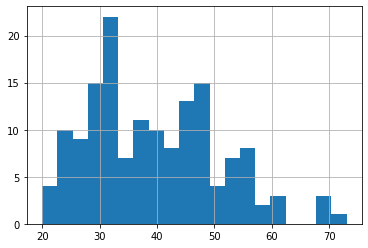

In [ ]:
dfy_winners_age = dfy_winners.query('age != 0')
dfy_winners_age['age'].hist(bins=20)
dfy_winners_age.to_csv('age_dist.csv')

In [ ]:
dfy_winners_described = round(dfy_winners.describe(),2)
dfy_winners_described.to_csv('q6_winners_described.csv', index=False)

([<matplotlib.axis.XTick at 0x7f29207ff790>,
 <a list of 12 Text major ticklabel objects>)

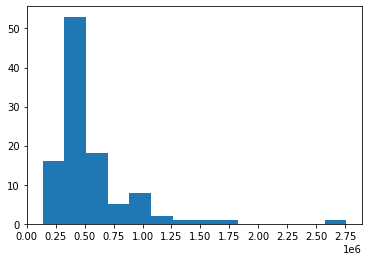

In [ ]:
dfy_winners_credit = dfy_winners.query('credit != 0')
plt.hist(dfy_winners_credit['credit'], bins=14)
#dfy_winners_credit['credit'].hist(bins=10)
dfy_winners_credit.to_csv('credit_dist.csv')
plt.xticks([0, 250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,2500000, 2750000])

In [ ]:
win_credit = round(dfy_winners_credit['credit'].describe(),2)
win_credit.to_csv('q6_credit_described.csv', index=False)
dfy_winners_credit.to_csv('q6_credit.csv', index=False)